# Análise de saúde mental no ambiente de trabalho

#### Dataset: https://www.kaggle.com/osmi/mental-health-in-tech-survey

## Informações do conjunto de dados

Este conjunto de dados é de uma pesquisa de 2014 que mede atitudes em relação à saúde mental e a frequência de
distúrbios de saúde mental no ambiente de trabalho técnico.


## Previsão
X = mental_health_consequence, treatment, family_history, leave

Y = work_interfere

 - mental_health_consequence: Você acha que discutir um problema de saúde mental com seu empregador
   teria consequências negativas?
 - treatment: Você procurou tratamento para uma condição de saúde mental?
 - family_history: Você tem um histórico familiar de doença mental?
 - leave: Quão fácil é para você tirar uma licença médica para uma condição de saúde mental?
 - work_interfere: Se você tem uma condição de saúde mental, sente que ela interfere no seu trabalho?

In [1]:
import pandas as pd
import numpy as np
from fastai_utils import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tech = pd.read_csv("tech/survey.csv", low_memory=False, sep=',')

# Limpeza

Os dados possuem muitos problemas por haver muitos campos com strings. Além disso, por ser um questionário, algumas perguntas foram de campo aberto (e.g. gênero), gerando dados inconsistentes.

### Seleção de colunas

Primeiramente, para economizar espaço, vamos cortar as colunas que não utilizaremos no projeto.

In [3]:
tech = tech.drop(['comments','state','Timestamp','Country'], axis= 1)

### Limpeza de valores nulos

Para uma boa classificação, não é bom haver valores nulos. Nesta parte, preencheremos os campos nulos com valores padrão do tipo daquela coluna.

In [4]:
defaultInt = 0
defaultString = 'NaN'

intFeatures = ['Age']
stringFeatures = ['Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']

for feature in tech:
    if feature in intFeatures:
        tech[feature] = tech[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        tech[feature] = tech[feature].fillna(defaultString)

### Limpeza e rotulação da coluna de gênero

A coluna de gênero contém muitas categorias que podem ser simplificadas. Aqui, realizamos este procedimento categorizando todos os valores dentro de 3 conjuntos: male, female e trans.

In [5]:
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in tech.iterrows():

    if str.lower(col.Gender) in male_str:
        tech['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        tech['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        tech['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

stk_list = ['A little about you', 'p']
tech = tech[~tech['Gender'].isin(stk_list)]

### Limpeza da coluna de idade

Existem alguns valores irreais em idade, como números negativos e números muito elevados. Visto isso, tratamos esses outliers igualando-os à média dos valores do conjunto.

In [6]:
tech['Age'].fillna(tech['Age'].median(), inplace = True)

s = pd.Series(tech['Age'])
s[(s<18) & (s>100)] = tech['Age'].median()
tech['Age'] = s

### Rotulação de valores nulos

Alguns valores nulos podem ser interpretados baseado em outras respostas do questionário. Assim, alguns valores nulos são populados com outros valores categóricos. 

In [7]:
tech['self_employed'] = tech['self_employed'].replace([defaultString], 'No')
tech['work_interfere'] = tech['work_interfere'].replace([defaultString], 'Don\'t have mental condition')

### Simplificação do campo para classificação

Os valores do campo work_interfere são graduais quanto ao impacto negativo da doença mental na produtividade do colaborador. Como temos relativamente poucas amostras, é mais difícil classificar tal campo levando em conta todos os graus de impacto. Desse modo, vamos simplificar o campo para uma categoria binária, sendo 'Yes' para quem sofre e 'No' para quem não sofre.

In [8]:
for (row, col) in tech.iterrows():
    if col.work_interfere == 'Never':
        tech['work_interfere'].replace(to_replace=col.work_interfere, value='No', inplace=True)
    if col.work_interfere == 'Sometimes':
        tech['work_interfere'].replace(to_replace=col.work_interfere, value='Yes', inplace=True)
    if col.work_interfere == 'Often':
        tech['work_interfere'].replace(to_replace=col.work_interfere, value='Yes', inplace=True)
    if col.work_interfere == 'Rarely':
        tech['work_interfere'].replace(to_replace=col.work_interfere, value='Yes', inplace=True)
    if col.work_interfere == 'Don\'t have mental condition':
        tech['work_interfere'].replace(to_replace=col.work_interfere, value='No', inplace=True)

# Hipóteses

## Abertura

Sentir-se aberto sobre o tema de doença mental ajuda em muito os pacientes que sofrem desse mal. No ambiente de trabalho, este fato também pode ser tão importante quanto para avaliar a perda de produtividade de um funcionário em decorrência da saúde mental. Vamos analisar algumas variáveis sobre esse tema. Dentre eles, olhamos primeiro para a percepção de consequência negativa no amebiente de trabalho:

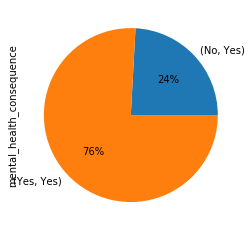

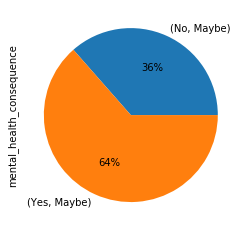

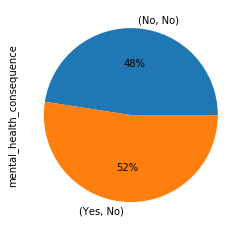

In [9]:
tech[tech['mental_health_consequence'] == 'Yes'].groupby(['work_interfere'])['mental_health_consequence'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()
tech[tech['mental_health_consequence'] == 'Maybe'].groupby(['work_interfere'])['mental_health_consequence'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()
tech[tech['mental_health_consequence'] == 'No'].groupby(['work_interfere'])['mental_health_consequence'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

Esses gráficos mostram como a percepção está ligada com o impacto negativo da doença mental no trabalho. Aquelas que dizem ter uma percepção negativa possuem 75% de chances de sentir impacto. Já aquelas que não julgam ter um ambiente negativo, apenas 50% não sente o impacto da saúde mental precária.

## Apoio

O apoio direto da empresa quanto ao tratamento da doença mental pode ser algo importante para seus funcionários, visto que a empresa se mostra abertamente interessada a combater essa questão. Assim, vamos analisar alguns pontos que podem comprovar essa hipótese. Dentre eles, temos a coluna de licença médica, classificando o quão difícil é conseguir tal benefício para problemas de doença mental. Vamos analisá-lo sob a ótica da interferência no trabalho:

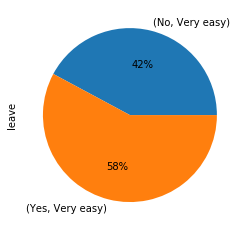

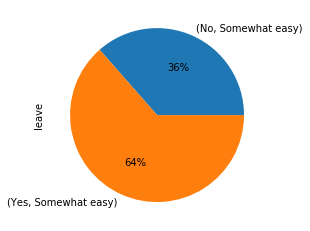

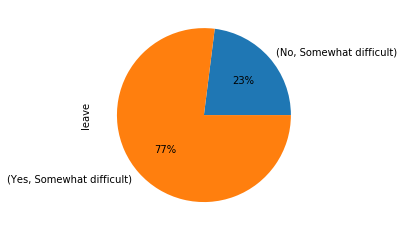

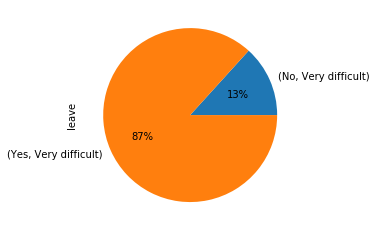

In [10]:
tech[tech['leave'] == 'Very easy'].groupby(['work_interfere'])['leave'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()
tech[tech['leave'] == 'Somewhat easy'].groupby(['work_interfere'])['leave'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()
tech[tech['leave'] == 'Somewhat difficult'].groupby(['work_interfere'])['leave'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()
tech[tech['leave'] == 'Very difficult'].groupby(['work_interfere'])['leave'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

Esses resultados são bem interessantes pois vemos que, o quão mais difícil é adquirir uma licença médica, mais impactante é a doença mental para àquele colaborador no ambiente de trabalho.

## Pessoal

A hipótese de Pessoal busca conhecer a relação das características pessoais do colaborador com o possível impacto da doença mental no trabalho. Em primeira análise, vamos olhar em como o gênero do indivíduo se correlaciona com o impacto que ele sofre no trabalho:

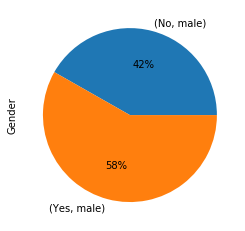

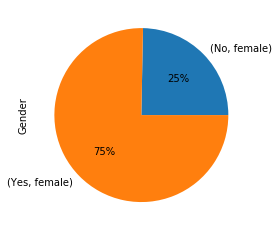

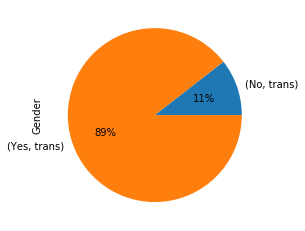

In [11]:
tech[tech['Gender'] == 'male'].groupby(['work_interfere'])['Gender'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()
tech[tech['Gender'] == 'female'].groupby(['work_interfere'])['Gender'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()
tech[tech['Gender'] == 'trans'].groupby(['work_interfere'])['Gender'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

Podemos ver que homens sofrem menos com doença mental, chegando em menos de 60% da amostragem. Em outra mão, quase 90% dos transexuais estão sofrendo atualmente. Quando olhamos para as mulheres, três quartos sofrem no ambiente de trabalho.

Outro ponto interessante é olhar para o histórico de distúrbios mentais do colaborador. Temos dados sobre a hereditariedade e estado do tratamento da doença mental. Faremos dois gráficos de barras sobre isso a seguir:

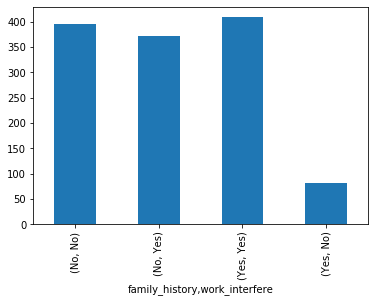

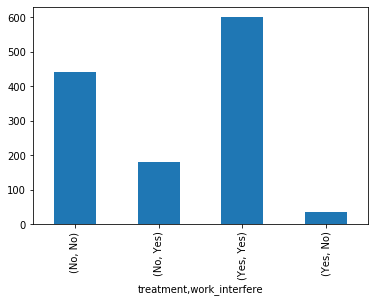

In [12]:
tech.groupby(['family_history'])['work_interfere'].value_counts().plot(kind='bar')
plt.show()
tech.groupby(['treatment'])['work_interfere'].value_counts().plot(kind='bar')
plt.show()

Encontramos alguns insights interessantes. Primeiramente, quase todas as pessoas que possuem hereditariedade também possuem problemas com doença mental no trabalho. Já sobre o tratamento da doença, vemos algo que nos poderia ajudar mais ainda: aqueles que já estão em tratamento sentem algum impacto no ambiente de trabalho, enquanto aqueles que não se tratam normalmente não sentem, indicando que talvez não tenham mesmo uma doença mental.

# Classificação

Como objetivo do trabalho, vamos classificar se o colaborador sofre ou não com a doença mental utlizando 3 classificadores: Naive Bayes, K-Neighbors e Random Forests.

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
gnb = GaussianNB()
m = RandomForestClassifier(n_jobs=-1)
k = KNeighborsClassifier(n_neighbors=100, weights='distance')

### Quantificar variáveis categóricas

Para trabalhar com strings, vamos transformar todas os valores em valores categóricos. Ou seja, daremos um valor numérico inteiro para cada possível string em um campo. Tentaremos sempre encontrar uma lógica para ordenar os valores, como no caso em que há 'Yes', 'Maybe' e 'No', dando 2, 1 e 0 respectivamente para cada string.

In [43]:
for (row, col) in tech.iterrows():

    if col.Gender == 'male':
        tech['Gender'].replace(to_replace=col.Gender, value=0, inplace=True)
    if col.Gender == 'female':
        tech['Gender'].replace(to_replace=col.Gender, value=1, inplace=True)
    if col.Gender == 'trans':
        tech['Gender'].replace(to_replace=col.Gender, value=2, inplace=True)
    if col.mental_health_consequence == 'No':
        tech['mental_health_consequence'].replace(to_replace=col.mental_health_consequence, value=0, inplace=True)
    if col.mental_health_consequence == 'Maybe':
        tech['mental_health_consequence'].replace(to_replace=col.mental_health_consequence, value=1, inplace=True)
    if col.mental_health_consequence == 'Yes':
        tech['mental_health_consequence'].replace(to_replace=col.mental_health_consequence, value=2, inplace=True)
    if col.family_history == 'Yes':
        tech['family_history'].replace(to_replace=col.family_history, value=1, inplace=True)
    if col.family_history == 'No':
        tech['family_history'].replace(to_replace=col.family_history, value=0, inplace=True)
    if col.treatment == 'Yes':
        tech['treatment'].replace(to_replace=col.treatment, value=1, inplace=True)
    if col.treatment == 'No':
        tech['treatment'].replace(to_replace=col.treatment, value=0, inplace=True)
    if col.leave == 'Don\'t know':
        tech['leave'].replace(to_replace=col.leave, value=0, inplace=True)
    if col.leave == 'Very easy':
        tech['leave'].replace(to_replace=col.leave, value=1, inplace=True)
    if col.leave == 'Somewhat easy':
        tech['leave'].replace(to_replace=col.leave, value=2, inplace=True)
    if col.leave == 'Somewhat difficult':
        tech['leave'].replace(to_replace=col.leave, value=3, inplace=True)
    if col.leave == 'Very difficult':
        tech['leave'].replace(to_replace=col.leave, value=4, inplace=True)
    if col.remote_work == 'Yes':
        tech['remote_work'].replace(to_replace=col.remote_work, value=1, inplace=True)
    if col.remote_work == 'No':
        tech['remote_work'].replace(to_replace=col.remote_work, value=0, inplace=True)
    if col.benefits == 'No':
        tech['benefits'].replace(to_replace=col.benefits, value=0, inplace=True)
    if col.benefits == 'Don\'t know':
        tech['benefits'].replace(to_replace=col.benefits, value=1, inplace=True)
    if col.benefits == 'Yes':
        tech['benefits'].replace(to_replace=col.benefits, value=2, inplace=True)

### Treinamento

Antes de treinar e classificar, vamos separar os dados em teste e treinamento. Outro ponto a ser discutidos é quais colunas usaremos para a classificação. Baseado nas hipósteses e testes feitos durante a realização desse projeto, selecionamos as colunas abaixo no código como as melhores

In [52]:
X = tech[['mental_health_consequence','treatment','family_history','leave']]
Y = tech['work_interfere']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)

y_pred_nb = gnb.fit(X_train, Y_train).predict(X_test)

y_pred_rf = m.fit(X_train, Y_train).score(X_test, Y_test)

y_pred_kn = k.fit(X_train, Y_train).predict(X_test)

Acertos do Naive bayes:

In [53]:
sum(y_pred_nb == Y_test) / len(y_pred_nb)

0.8317460317460318

Acertos do K-Neighbors

In [54]:
sum(y_pred_kn == Y_test) / len(y_pred_kn)

0.8507936507936508

Acertos do Random Forest

In [55]:
y_pred_rf

0.8571428571428571

Obtivemos bons resultados com as colunas selecionadas. Dentre os classificadores, o Random Forest obteve o melhor desempenho com 85.7% de acertos. Como comparativo, K-Neighbors obteve 85.1% e Naive Bayes 83.2%.

Concluindo, é possível sim fazer uma predição sobre o impacto da doença mental sobre os colaboradores de uma empresa, visto que estes resultados foram alcançados em poucos dias de trabalho. Ou seja, há ainda muito espaço para melhorias.
Como impactos desse trabalho, podemos citar a criação de programas de concientização e benefícios personalizados para colabores de empresas que se enquadram como portadores de saúde mental. Também é necessário se atentar à questão de diversidade: mulheres e trans sofrem mais com esse tipo de situação. Com mais amostras e tempo de trabalho, podemos chegar à mais insights e recomendações par ao problema.